# New Hire - Contribute to HSA

Ensure new hires who enroll in  HDHP will also open and contribute to HSA within 30 days.

Predict  which new hires are likely to enroll in HDHP but are not likely to open and contribute to the HSA within 30 days.

For this analysis and modeling we are solely using *person_hm_choice_enrolled_integrated* (PHCE) table and we have tweaked the "not likely to open and contribute to the HSA within 30 days from *hire date*" to  "not likely to open and contribute to the HSA within 30 days from *first date when they did new hire enrollment in hdhp medical plan*".

---
In this notebook, below steps are performed
- Pre-process the new unseen raw data
- Tranform above pre-processed data to make it ready for predcitions
- Use pre-trained ML model to make predictions on above transformed data

<font color='red'>
We need to edit below six cells before running the whole script.
    
If not editted, data will be pulled and stored from S3 bucket as per given values.
</font>

### For Loading Raw Data

In [2]:
# Mention the bucket name where raw data is present
bucket='adl-core-dev-sagemaker-studio'

# # This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# # Mention the version whre data is stored in given S3 bucket
# version = 'version-1'

# Mention the correct directory where raw-data is present, if data is in multiple files make sure all files are present in this directory
raw_data_path = f'external/amitmittal/HSA/test-data'

# Mention all file names as string in the below list
raw_data_fnames = ['ALL_2022.csv']

### For X days logic for creating target variable 

In [3]:
# n-> number of days to look forward and check of participant is contributing in HSA or not.
# At time this use-case was worked upon, it was 30 days, so 'n' is taken as 30
# This value is use at code line 26
n = 30

### For Storing Pre-processed Data
Same directory and file will be used to load data for transformation step

In [4]:
# Mention the bucket name where pre-processed data will be stored. Usually there will no change in bucket name
bucket='adl-core-dev-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
#Make sure "version" name is as per version of data pre-processing script. Eg. dpp0-xgb-v1.ipynb means "version-1"
version = 'version-1'

# Mention the directory where pre-processed data will be stored with file name
pre_processed_data_path_with_fname = f'external/amitmittal/HSA/test-data/output/{version}/preprocessed-data/data2022.csv'

### For Storing Transformed Data
Same directory and file will be used to load data for making predictions using trained ML model

In [5]:
# Mention the bucket name where transformed data will be stored. Usually there will no change in bucket name
bucket='adl-core-dev-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
#Make sure "version" name is as per version of data pre-processing script. Eg. dpp0-xgb-v1.ipynb means "version-1"
version = 'version-1'

# This is used to seperate different versions of data transformation pipelines
# Make sure "dppn" name is as per version of data transformation script. Eg. dpp0-xgb-v1.ipynb means "dpp0"
dppn = 'dpp0'

# Mention the directory where pre-processed data will be stored (data that will get at end of this script)
transformed_data_path_with_fname = f'external/amitmittal/HSA/test-data/output/{version}/transformed-data/{dppn}/data2022.csv'

### For Loading Train Set
This is pre-processed data of the train set on which ML model was trained.

Train set will be used to fit and transform the data tranformation setps on train set and only transformation will be done on test (new) data using train set 

In [6]:
# Mention the bucket name where pre-processed raw data is stored (of training set)
bucket='adl-core-dev-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# Mention the version whre data is stored in given S3 bucket
version = 'version-1'

# Mention the path where pre-processed data is stored in S3
pre_processed_train_data_path = f'external/amitmittal/HSA/{version}/preprocessed-data'

### For Loading Trained ML Model
This model will be used to make predictions on tranformed test (new) data 

In [7]:
# Mention the bucket name where trained model will is stored 
bucket='adl-core-dev-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# Make sure "version" name is as per version of data data modeling script. Eg. data-modeling-v1.ipynb means "version-1"
version = 'version-1'

# This is used to seperate different versions of models which were built using different data transformation pipelines
# Make sure "dppn" name is as per version of data transformation script. Eg. transformed-data-dpp0-v1.ipynb means "dpp0"
dppn = 'dpp0'

# Mention the directory with file name where trained ML model is stored (naming convention: version-dppn-model.pkl)
model_path_with_fname = f'external/amitmittal/HSA/{version}/artifacts/model/v1-{dppn}-xgb.pkl'

In [7]:
!pip install --upgrade pandas --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [8]:
#importing librarires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import boto3
import io
import time

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score,\
roc_auc_score, make_scorer, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix, average_precision_score,\
ConfusionMatrixDisplay

import tempfile
import boto3
import joblib

%matplotlib inline
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [9]:
def load_data_from_s3(bucket,version,raw_data_path,raw_data_fnames):
    s3 = boto3.client('s3')
    dataset_nrows = []
    for i, fname in enumerate(raw_data_fnames):
        if i==0:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data = pd.read_csv(io.BytesIO(obj['Body'].read()))
            dataset_nrows.append(data.shape[0])
            print(f'\tFile read successfully | Shape: {data.shape}')
        else:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data2 = pd.read_csv(io.BytesIO(obj['Body'].read()))
            data = data.append(data2,ignore_index=True)
            dataset_nrows.append(data2.shape[0])
            print(f'\tFile read successfully | Shape: {data2.shape}')

    if sum(dataset_nrows) == data.shape[0]:
        print(f'Data from all files loaded successfully | Final Shape: {data.shape}')
        return data.copy()
    else:
        print('There is discrepency in numbers')
        print(f'\tTotal number of rows combined in all files: {sum(dataset_nrows)}')
        print(f'\tAfter combining all files total number of rows are: {data.shape[0]}')
        return None

In [10]:
data = load_data_from_s3(bucket,version,raw_data_path,raw_data_fnames)

Reading file: ALL_2022.csv
	File read successfully | Shape: (1063575, 35)
Data from all files loaded successfully | Final Shape: (1063575, 35)


In [11]:
data.shape

(1063575, 35)

#### Updating data type of date columns

In [12]:
data['activity_effective_begin_date'] = data['activity_effective_begin_date'].replace('2299-12-31 00:00:00','2261-12-31 00:00:00')
data['activity_effective_begin_date'] = pd.to_datetime(data['activity_effective_begin_date'], format='%Y-%m-%d %H:%M:%S')

In [13]:
data['activity_effective_begin_date'].head()

0   2022-01-01
1   2022-01-01
2   2022-01-01
3   2022-01-01
4   2022-01-01
Name: activity_effective_begin_date, dtype: datetime64[ns]

Since we know that `ee_hsa_contribution_flag` and `er_hsa_contribution_flag` are not reliable. Therefore, we will be creating correct flag columns using respective columns.

In [14]:
data['enrolled_ee_annual_hsa_contribution']
data['ee_hsa_contribution_flag_new'] = 0
data.loc[
    data['enrolled_ee_annual_hsa_contribution'] > 0,
    'ee_hsa_contribution_flag_new'
] = 1

In [15]:
data['enrolled_er_annual_hsa_contribution']
data['er_hsa_contribution_flag_new'] = 0
data.loc[
    data['enrolled_er_annual_hsa_contribution'] > 0,
    'er_hsa_contribution_flag_new'
] = 1

In [16]:
#### Identifying new hires enrolled in any medical plan
# df['new_hire_enrolled_medical_plan'] = 0
# df.loc[
#     (df['mapped_activity_rollup_level_2']=='New Hire Enrollment') &
#     (df['is_no_coverage_option']==0) &
#     (df['dwh_plan_brand_code'].str.contains('MDCL|MDCL-MDCR|RTEE-MDCL')),
#     'new_hire_enrolled_medical_plan'
# ] = 1

#### Identifying new hires enrolled in HDHP medical plan

In [17]:
data['new_hire_enrolled_hdhp_medical_plan'] = 0
data.loc[
    (
        (data['source_system']=='TBA_4X') &
        (data['mapped_activity_rollup_level_2']=='New Hire Enrollment') &
        (data['is_no_coverage_option']==0) &
        (data['dwh_plan_brand_code'].isin(['MDCL','MDCL-MDCR','RTEE-MDCL'])) &
        (data['is_option_hsa_fixed']=='HSA') &
        (data['medical_enrolled_option_type']=='HDHP')
    ) |
    (
        (data['source_system']=='CBA') &
        (data['mapped_activity_rollup_level_2']=='Other Enrollment') &
        (data['is_no_coverage_option']==0) &
        (data['dwh_plan_brand_code'].isin(['MDCL','MDCL-MDCR','RTEE-MDCL'])) &
        (data['is_option_hsa_fixed']=='HSA') &
        (data['medical_enrolled_option_type']=='HDHP')
    ) |
    (
        (data['source_system']=='TBA_3X') &
        (data['mapped_activity_rollup_level_2']=='New Hire Enrollment') &
        (data['is_no_coverage_option']==0) &
        (data['dwh_plan_brand_code']=='HSA')
    ),
    'new_hire_enrolled_hdhp_medical_plan'
] = 1

In [18]:
#unique count of person who enrolled in HDHP medical plan
data[data['new_hire_enrolled_hdhp_medical_plan']==1]['platform_person_internal_id'].nunique()

276612

In [19]:
data['platform_person_internal_id'].nunique()

276612

In [20]:
# #### Identifying new hires enrolled in HDHP medical plan and contributing to HSA - at time of New Hire Enrollment
# data['new_hire_enrolled_hdhp_medical_plan_contributing_hsa'] = 0
# data.loc[
#     (
#         (data['source_system']=='TBA_4X') &
#         (data['mapped_activity_rollup_level_2']=='New Hire Enrollment') &
#         (data['is_no_coverage_option']==0) &
#         (data['dwh_plan_brand_code'].isin(['MDCL','MDCL-MDCR','RTEE-MDCL'])) &
#         (data['is_option_hsa_fixed']=='HSA') &
#         (data['medical_enrolled_option_type']=='HDHP') &
#         (data['ee_hsa_contribution_flag_new']==1)
#     ) |
#     (
#         (data['source_system']=='CBA') &
#         (data['mapped_activity_rollup_level_2']=='Other Enrollment') &
#         (data['is_no_coverage_option']==0) &
#         (data['dwh_plan_brand_code'].isin(['MDCL','MDCL-MDCR','RTEE-MDCL'])) &
#         (data['is_option_hsa_fixed']=='HSA') &
#         (data['medical_enrolled_option_type']=='HDHP') &
#         (data['ee_hsa_contribution_flag_new']==1)
#     ) |
#     (
#         (data['source_system']=='TBA_3X') &
#         (data['mapped_activity_rollup_level_2']=='New Hire Enrollment') &
#         (data['is_no_coverage_option']==0) &
#         (data['dwh_plan_brand_code']=='HSA') &
#         (data['ee_hsa_contribution_flag_new']==1)
#     ),
#     'new_hire_enrolled_hdhp_medical_plan_contributing_hsa'
# ] = 1

### Filtering data for partcipants who had new hire enrollment in HDHP medical plan
Exlcuding person's data who did not had new hire enrollment in HDHP medical plan.

In [21]:
#filtering data for particpants who had new_hire_enrolled_hdhp_medical_plan=1 at some point of time in the given year
ppid_enrolled_hdhp = data[data['new_hire_enrolled_hdhp_medical_plan']==1]['platform_person_internal_id'].unique()
df = data[data['platform_person_internal_id'].isin(ppid_enrolled_hdhp)]
del ppid_enrolled_hdhp
df.shape

(1063575, 38)

In [22]:
#sorting data by participant and activity begin date -> to mark row number for each particant
df = df.sort_values(['platform_person_internal_id','activity_effective_begin_date'],ascending=True)
df.shape

(1063575, 38)

In [23]:
#creating this column to create another column which will duplicate minimum activity begin date corrsoponding to new hire enrollment in
#in HSHP type of medical plan for each participant
df['activity_begin_date_nhehmp'] = pd.NaT
df.loc[df['new_hire_enrolled_hdhp_medical_plan']==1,'activity_begin_date_nhehmp'] = df['activity_effective_begin_date']

In [24]:
#creating column to capture first activity start date corrsponding to new hire enrollment in HDHP medical plan for particpants 
df['min_activity_begin_date_nhehmp'] = df.groupby('platform_person_internal_id')['activity_begin_date_nhehmp'].transform(lambda x: x.min())

In [25]:
#checking for nulls
df['min_activity_begin_date_nhehmp'].isnull().sum()

0

In [26]:
#creating this column to create row number column for each particpant
#this will flag row as 1 if activity_effective_begin_date > min_activity_begin_date_nhehmp
# in case activity_effective_begin_date = min_activity_begin_date_nhehmp then if activity_begin_date_nhehmp not NULL then 1 else 0
#above logic is implemented, in case we have muplitple rows with same date as min_activity_begin_date_nhehmp then to assign flag as 1
#only to rows where new hire enrollment to HDHP medical plan was done
df['activity_begin_date_nhehmp_ge_min'] = 0
df.loc[(df['activity_effective_begin_date']>df['min_activity_begin_date_nhehmp']), 'activity_begin_date_nhehmp_ge_min'] = 1
df.loc[(df['activity_effective_begin_date']==df['min_activity_begin_date_nhehmp']) & (df['activity_begin_date_nhehmp'].notnull()), 'activity_begin_date_nhehmp_ge_min'] = 1

In [27]:
#assigning row number for each particpant's rows where activity_begin_date_nhehmp_ge_min=1, and we can use row number =1 to capture
#first row for each particpant when theyhad new hire enrollemnt in HDHP medical plan
df['ppid_rnum'] = df[df['activity_begin_date_nhehmp_ge_min']==1].groupby('platform_person_internal_id')['activity_effective_begin_date'].transform(lambda x: range(1,len(x)+1))

In [28]:
#checking for nulls, having nulls is not a problem. We only need to condier row number = 1 for each particpant
#while brining the dataset to one row per participant 
df['ppid_rnum'].isnull().sum()

605687

#### Creating Label column

In [29]:
#creating this column to help create label column
#this will check days difference between first new hire enrollment in HDHP medical plan activity date and respective row activity date
#if the difference is less than or equal to specified number 'n' then it flag respective row as 1 else 0
# 'n' is mentioned at start of the script
df['activity_begin_date_within_30d_flag'] = 0
df.loc[(df['activity_effective_begin_date']-df['min_activity_begin_date_nhehmp']).dt.days.isin(range(n+1)), 'activity_begin_date_within_30d_flag']=1
df.shape

(1063575, 43)

In [30]:
#checking for nulls, we do not expect nulls here
df['activity_begin_date_within_30d_flag'].isnull().sum()

0

In [31]:
#finally we are creating label column
#logic: if the particpant contributed in HSA within 30 days of forst new hire enrollment in HDHP mencial plan for given enrolled_plan_year
#not necessaryly at time of enrollment then rows for the particpant will be flaged as 1 else 0
#also there is not checks on other columns while considering ee_hsa_contribution_flag=1
#column will have null values for rows where activity_begin_date_within_30d_flag=0, irrespecitve of particpant contributing or not in HSA
#we can change the look forward days 30 days to any days by changing value of variable 'n' and re-running code for creating
#'activity_begin_date_within_30d_flag' and 'label' columns
df['label'] = df[df['activity_begin_date_within_30d_flag']==1].groupby('platform_person_internal_id')['ee_hsa_contribution_flag_new'].transform(lambda x: x.max())
df.shape

(1063575, 44)

In [32]:
#droping supporting columns used to create label column
df.drop(
    columns=['activity_begin_date_nhehmp',
             'min_activity_begin_date_nhehmp',
             'activity_begin_date_nhehmp_ge_min',
             'activity_begin_date_within_30d_flag'
            ],
    inplace=True
)

#### Creating new dataframe - one row per person

In [33]:
#condering only row number 1 for each particpant to bring down data at particpant leve;
df = df[df['ppid_rnum']==1]
df.shape

(276612, 40)

In [34]:
#checking unique count of participants
df['platform_person_internal_id'].nunique()

276612

In [35]:
#chekcing count of particpants contributing in HSA within 30 days of new hire enrollement in HDHP medical plan vs not
# 1 -> contributing, 0 -> not contributing within 30 days 
df['label'].value_counts()

1.0    145620
0.0    130992
Name: label, dtype: int64

In [36]:
#reversing 1 <-> 0, not label (target column is align with problem statement)
# 1 -> particpants NOT CONTRINUTING TO HSA within 30 days of first new hire enrollement date in HDHP medical plan
# 0 -> particpants CONTRINUTING TO HSA within 30 days of first new hire enrollement date in HDHP medical plan
df['label'] = df['label'].map({0:1,1:0})
df['label'].value_counts()

0    145620
1    130992
Name: label, dtype: int64

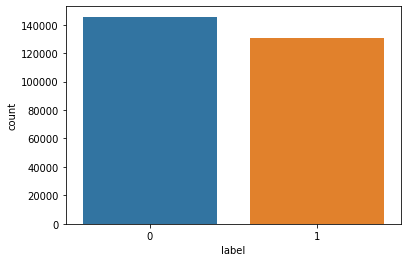

In [37]:
#checking distribution of target feature
sns.countplot(data=df, x='label')
plt.show()

In [38]:
#droping some more columns that were used to create desired dataset
drop_columns = ['ppid_rnum','new_hire_enrolled_hdhp_medical_plan',
                'er_hsa_contribution_flag','ee_hsa_contribution_flag_new','enrolled_plan_year','enrolled_person_plan_efenddt',
                'enrolled_person_plan_efbegdt','activity_effective_begin_date','ee_hsa_contribution_flag',
                'enrolled_ee_annual_hsa_contribution','medical_enrolled_option_type','is_option_hsa_fixed','dwh_plan_brand_code',
                'is_no_coverage_option','mapped_activity_rollup_level_2']

df.drop(
    columns=drop_columns,
    inplace=True
)

df.shape

In [39]:
df.head(3)

,platform_id,client_id,client_name,client_industry,platform_person_internal_id,enrolled_option_description,enrolled_plan_cost,enrolled_annual_paycheck_deduction,person_age,person_gender_description,marital_status_description,person_expected_annual_base_salary,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,mapped_person_employment_status_standard_value,mapped_enrolled_coverage_category_standard_value,source_system,enrollment_suggestion_source,enrolled_option_brand_code,enrolled_option_description_group,er_hsa_contribution_flag_new,label
993672,10021,7961,Airgas; Inc. - HWE,Wholesale,10021/100690028,Blue Cross PPO - Bronze w HSA,4394.0,6594.04,44.0,Male,Single,65000.0,Y,N,EB,4.0,0.0,Active,Participant and Family,TBA_4X,Others,CDP-MDCL-SA-POS,NaN,0,0
351106,10021,10801,Expedia; Inc.,Entertainment;Travel and Leisure,10021/100690083,Aetna Health Savings Plan,420.0,3320.00,22.0,Male,Single,NaN,N,N,EB,1.0,750.0,NaN,Participant Only,TBA_4X,UPoint Reimagine,PPO,NaN,1,0
361919,10021,12467,BlackRock; Inc.,Insurance,10021/100690090,Core Health Savings PPO - UHC,0.0,0.00,50.0,Male,Single,300000.0,Y,N,EB,1.0,0.0,Active,Participant Only,TBA_4X,Others,PPO,NaN,0,1


### Exporting pre-processed data to S3

In [41]:
print(f'Uploading pre-processed data here -> s3://{bucket}/{pre_processed_data_path_with_fname}')

df.to_csv(f's3://{bucket}/{pre_processed_data_path_with_fname}', index=False)

Uploading pre-processed data here -> s3://adl-core-dev-sagemaker-studio/external/amitmittal/HSA/test-data/output/version-1/preprocessed-data/data2022.csv


-----
## Data Transformation

In [42]:
%%time
#importing raw dataset
s3 = boto3.client('s3')
key = f'{pre_processed_data_path_with_fname}'
obj = s3.get_object(Bucket=bucket, Key=key)
ppd = pd.read_csv(io.BytesIO(obj['Body'].read()))
ppd.shape

CPU times: user 848 ms, sys: 122 ms, total: 970 ms
Wall time: 1.75 s


(276612, 25)

In [43]:
ppd.head(3)

,platform_id,client_id,client_name,client_industry,platform_person_internal_id,enrolled_option_description,enrolled_plan_cost,enrolled_annual_paycheck_deduction,person_age,person_gender_description,marital_status_description,person_expected_annual_base_salary,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,mapped_person_employment_status_standard_value,mapped_enrolled_coverage_category_standard_value,source_system,enrollment_suggestion_source,enrolled_option_brand_code,enrolled_option_description_group,er_hsa_contribution_flag_new,label
0,10021,7961,Airgas; Inc. - HWE,Wholesale,10021/100690028,Blue Cross PPO - Bronze w HSA,4394.0,6594.04,44.0,Male,Single,65000.0,Y,N,EB,4.0,0.0,Active,Participant and Family,TBA_4X,Others,CDP-MDCL-SA-POS,NaN,0,0
1,10021,10801,Expedia; Inc.,Entertainment;Travel and Leisure,10021/100690083,Aetna Health Savings Plan,420.0,3320.00,22.0,Male,Single,NaN,N,N,EB,1.0,750.0,NaN,Participant Only,TBA_4X,UPoint Reimagine,PPO,NaN,1,0
2,10021,12467,BlackRock; Inc.,Insurance,10021/100690090,Core Health Savings PPO - UHC,0.0,0.00,50.0,Male,Single,300000.0,Y,N,EB,1.0,0.0,Active,Participant Only,TBA_4X,Others,PPO,NaN,0,1


In [44]:
ppd['platform_person_internal_id'].nunique()

276612

In [45]:
def cat_vs_cat_plot(predictor):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    ppd.groupby(predictor, observed=True, dropna=False, sort=False)['platform_person_internal_id'].count().plot(kind='bar',stacked=True,color='skyblue',legend=False,ax=axes[0])
    #df[predictor].value_counts(sort=False).plot(kind='bar',ax=axes[0])
    ppd.groupby(predictor, observed=True, dropna=False, sort=False)['label'].value_counts(normalize=True).unstack().plot(kind='bar',stacked=True,ax=axes[1])
    plt.show()

In [46]:
def cat_vs_cont_plot(predictor):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    sns.boxplot(data=ppd, x=predictor, y='label', orient='h', ax=axes[0])
    sns.kdeplot(ppd[ppd['label']==0][predictor], shade=True, label=0, ax=axes[1])
    sns.kdeplot(ppd[ppd['label']==1][predictor], shade=True, label=1, ax=axes[1])
    plt.title(f'Count of NULL values in {predictor}: {ppd[predictor].isna().sum()}')
    plt.show()

In [47]:
ppd.select_dtypes('O').columns

Index(['client_name', 'client_industry', 'platform_person_internal_id',
       'enrolled_option_description', 'person_gender_description',
       'marital_status_description', 'client_is_ysa',
       'client_has_corporate_exchange', 'client_hm_large_market_or_enterprise',
       'mapped_person_employment_status_standard_value',
       'mapped_enrolled_coverage_category_standard_value', 'source_system',
       'enrollment_suggestion_source', 'enrolled_option_brand_code',
       'enrolled_option_description_group'],
      dtype='object')

In [48]:
agriculture_and_mining = ['Mining;Quarrying and Drilling','Agriculture; Forestry and Fishing']
banking_and_finance = ['Banking and Finance']
business_services = ['Rental and Leasing','Professional Services','Business and Personal Services','Business and Management Services']
computer_service_and_software = ['High Tech','Electronics','Computers']
consumer_misc_product_and_manufacturing = ['Repair and Maintenance']
diversified_manufacturing = ['Real Estate','Manufacturing','Construction and Building Materials','Chemicals','Architecture & Engineering','Aerospace and Defense']
education = ['Education']
food_and_beverage = ['Food and Beverage']
government = ['Public Sector and Government']
healthcare_and_medical = ['Pharmaceutical and Chemicals','Healthcare','Health Services','Biotechnology; Pharmaceuticals and Medicine']
insurance = ['Insurance']
retail = ['Wholesale','Retail']
telecom = ['Telecommunications and Publishings','Telecommunications Services']
transport_and_storage = ['Automotive and Transportation']
travel_recreation_and_leisure = ['Entertainment;Travel and Leisure']
utilities_and_energy = ['Utilities and Energy']
unknown = ['Unassigned','Not Applicable']

In [49]:
ppd.loc[ppd['client_industry'].isin(agriculture_and_mining), 'client_industry_rollup'] = 'agriculture_and_mining'
ppd.loc[ppd['client_industry'].isin(banking_and_finance), 'client_industry_rollup'] = 'banking_and_finance'
ppd.loc[ppd['client_industry'].isin(business_services), 'client_industry_rollup'] = 'business_services'
ppd.loc[ppd['client_industry'].isin(computer_service_and_software), 'client_industry_rollup'] = 'computer_service_and_software'
ppd.loc[ppd['client_industry'].isin(consumer_misc_product_and_manufacturing), 'client_industry_rollup'] = 'consumer_misc_product_and_manufacturing'
ppd.loc[ppd['client_industry'].isin(diversified_manufacturing), 'client_industry_rollup'] = 'diversified_manufacturing'
ppd.loc[ppd['client_industry'].isin(education), 'client_industry_rollup'] = 'education'
ppd.loc[ppd['client_industry'].isin(food_and_beverage), 'client_industry_rollup'] = 'food_and_beverage'
ppd.loc[ppd['client_industry'].isin(government), 'client_industry_rollup'] = 'government'
ppd.loc[ppd['client_industry'].isin(healthcare_and_medical), 'client_industry_rollup'] = 'healthcare_and_medical'
ppd.loc[ppd['client_industry'].isin(insurance), 'client_industry_rollup'] = 'insurance'
ppd.loc[ppd['client_industry'].isin(retail), 'client_industry_rollup'] = 'retail'
ppd.loc[ppd['client_industry'].isin(telecom), 'client_industry_rollup'] = 'telecom'
ppd.loc[ppd['client_industry'].isin(transport_and_storage), 'client_industry_rollup'] = 'transport_and_storage'
ppd.loc[ppd['client_industry'].isin(travel_recreation_and_leisure), 'client_industry_rollup'] = 'travel_recreation_and_leisure'
ppd.loc[ppd['client_industry'].isin(utilities_and_energy), 'client_industry_rollup'] = 'utilities_and_energy'
ppd.loc[ppd['client_industry'].isin(unknown), 'client_industry_rollup'] = 'Unknown'
ppd.loc[ppd['client_industry'].isnull(), 'client_industry_rollup'] = 'Unknown'

In [50]:
single_list = ['Single']
married_list = ['Married','Married - Qualified','Married - Domestic Partner']
divorce_list = ['Divorced','Separated','Widowed']
unknown_list = ['Unknown','Other','Invalid']

In [51]:
ppd.loc[ppd['marital_status_description'].isin(single_list), 'marital_status_rollup'] = 'Single'
ppd.loc[ppd['marital_status_description'].isin(married_list), 'marital_status_rollup'] = 'Married'
ppd.loc[ppd['marital_status_description'].isin(divorce_list), 'marital_status_rollup'] = 'Divorce'
ppd.loc[ppd['marital_status_description'].isin(unknown_list), 'marital_status_rollup'] = 'Unknown'
ppd.loc[ppd['marital_status_description'].isnull(), 'marital_status_rollup'] = 'Unknown'

In [52]:
active_list = ['Active','Disability - Long Term or Perm','Disability - Short Term','LOA - Family Medical','LOA - Military','LOA - no Pay','LOA - with Pay',"LOA - Worker's Compensation"]
inactive_list = ['COBRA Employee','Deceased - In Service','Deceased - Out-of-Service','Layoff','Retired','Severance Pay','Termination']
non_employee_list = ['COBRA Dependent','Enrolled Beneficiary','Enrolled QDRO']

In [53]:
ppd.loc[ppd['mapped_person_employment_status_standard_value'].isin(active_list), 'employment_status_rollup'] = 'Active'
ppd.loc[ppd['mapped_person_employment_status_standard_value'].isin(inactive_list), 'employment_status_rollup'] = 'Inactive'
ppd.loc[ppd['mapped_person_employment_status_standard_value'].isin(non_employee_list), 'employment_status_rollup'] = 'Non-Employee'
ppd.loc[ppd['mapped_person_employment_status_standard_value'].isnull(), 'employment_status_rollup'] = 'Unknown'

In [54]:
covering_self_list = ['Participant Only']
covering_family_list = ['Participant and Family','Participant and Child(ren)','Participant and Spouse','Participant and Dependent']
covering_others = ['Spouse Only','Spouse and Child(ren)','Child(ren) Only']

In [55]:
ppd.loc[ppd['mapped_enrolled_coverage_category_standard_value'].isin(covering_self_list), 'coverage_category_rollup'] = 'Covering_Self'
ppd.loc[ppd['mapped_enrolled_coverage_category_standard_value'].isin(covering_family_list), 'coverage_category_rollup'] = 'Covering_Family'
ppd.loc[ppd['mapped_enrolled_coverage_category_standard_value'].isin(covering_others), 'coverage_category_rollup'] = 'Covering_Others'
ppd.loc[ppd['mapped_enrolled_coverage_category_standard_value'].isnull(), 'coverage_category_rollup'] = 'Unknown'

In [56]:
ppd.loc[
    ppd['source_system']=='CBA'
    ,'enrolled_option_bc_dg'
] = ppd['enrolled_option_description_group']

ppd.loc[
    ppd['source_system']!='CBA'
    ,'enrolled_option_bc_dg'
] = ppd['enrolled_option_brand_code']

In [57]:
ppd.loc[
    ppd['person_age'] < 18,
    'person_age'
] = 18

In [58]:
bins = [-1, 19999, 39999, 59999, 79999, 99999, 999999999999]
labels = ['<20,000', '20,000 - 39,999', '40,000 - 59,999', '60,000 - 79,999', '80,000 - 99,999', '100,000+']
ppd['person_expected_annual_base_salary_range'] = pd.cut(x=ppd['person_expected_annual_base_salary'], bins=bins, labels=labels)

In [59]:
ppd['person_expected_annual_base_salary_range'] = ppd['person_expected_annual_base_salary_range'].astype(str)
ppd['person_expected_annual_base_salary_range'].replace(to_replace='nan',value='Unknown', inplace=True)

In [60]:
drop_columns = ['platform_id','client_id','client_name','platform_person_internal_id','enrolled_option_description',
                'enrolled_annual_paycheck_deduction','enrolled_option_brand_code','enrolled_option_description_group',
                'client_industry','marital_status_description','person_expected_annual_base_salary',
                 'mapped_person_employment_status_standard_value','mapped_enrolled_coverage_category_standard_value']

test_set = ppd.drop(columns=drop_columns)
test_set.shape

(276612, 18)

In [61]:
cat_columns = ['client_industry_rollup','person_gender_description','marital_status_rollup','client_is_ysa',
               'client_has_corporate_exchange','client_hm_large_market_or_enterprise','employment_status_rollup',
               'coverage_category_rollup','source_system','enrollment_suggestion_source','er_hsa_contribution_flag_new',
               'enrolled_option_bc_dg','person_expected_annual_base_salary_range']
num_columns = ['person_age','number_of_people_covered','enrolled_plan_cost','enrolled_er_annual_hsa_contribution']
print(len(cat_columns))
print(len(num_columns))

13
4


In [62]:
test_set[cat_columns] = test_set[cat_columns].fillna("Unknown")

test_set[cat_columns].isnull().sum()

client_industry_rollup                      0
person_gender_description                   0
marital_status_rollup                       0
client_is_ysa                               0
client_has_corporate_exchange               0
client_hm_large_market_or_enterprise        0
employment_status_rollup                    0
coverage_category_rollup                    0
source_system                               0
enrollment_suggestion_source                0
er_hsa_contribution_flag_new                0
enrolled_option_bc_dg                       0
person_expected_annual_base_salary_range    0
dtype: int64

### Loading Training Data

In [63]:
%%time
#importing raw dataset
s3 = boto3.client('s3')
key = f'{pre_processed_train_data_path}/data.csv'
obj = s3.get_object(Bucket=bucket, Key=key)
train_set = pd.read_csv(io.BytesIO(obj['Body'].read()))
train_set.shape

CPU times: user 1.4 s, sys: 234 ms, total: 1.63 s
Wall time: 4.87 s


(436719, 25)

In [64]:
train_set.shape

(436719, 25)

In [65]:
train_set.head(2)

,platform_id,client_id,client_name,client_industry,platform_person_internal_id,enrolled_option_description,enrolled_plan_cost,enrolled_annual_paycheck_deduction,person_age,person_gender_description,marital_status_description,person_expected_annual_base_salary,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,mapped_person_employment_status_standard_value,mapped_enrolled_coverage_category_standard_value,source_system,enrollment_suggestion_source,enrolled_option_brand_code,enrolled_option_description_group,er_hsa_contribution_flag_new,label
0,10021,9264,Stericycle; Inc.,Utilities and Energy,10021/100070010,HSA Basic Choice Plus,843.0,843.36,19.0,Male,Single,47840.0,Y,N,EB,1.0,0.0,Active,Participant Only,TBA_4X,UPoint Reimagine,CDP-MDCL-SA-PPO,NaN,0,1
1,10021,10801,Expedia; Inc.,Entertainment;Travel and Leisure,10021/100390006,Aetna Health Savings Plan,2076.0,2076.00,28.0,Female,Single,57000.0,N,N,EB,2.0,1500.0,Active,Participant and Spouse,TBA_4X,Others,PPO,NaN,1,1


In [66]:
train_set.loc[train_set['client_industry'].isin(agriculture_and_mining), 'client_industry_rollup'] = 'agriculture_and_mining'
train_set.loc[train_set['client_industry'].isin(banking_and_finance), 'client_industry_rollup'] = 'banking_and_finance'
train_set.loc[train_set['client_industry'].isin(business_services), 'client_industry_rollup'] = 'business_services'
train_set.loc[train_set['client_industry'].isin(computer_service_and_software), 'client_industry_rollup'] = 'computer_service_and_software'
train_set.loc[train_set['client_industry'].isin(consumer_misc_product_and_manufacturing), 'client_industry_rollup'] = 'consumer_misc_product_and_manufacturing'
train_set.loc[train_set['client_industry'].isin(diversified_manufacturing), 'client_industry_rollup'] = 'diversified_manufacturing'
train_set.loc[train_set['client_industry'].isin(education), 'client_industry_rollup'] = 'education'
train_set.loc[train_set['client_industry'].isin(food_and_beverage), 'client_industry_rollup'] = 'food_and_beverage'
train_set.loc[train_set['client_industry'].isin(government), 'client_industry_rollup'] = 'government'
train_set.loc[train_set['client_industry'].isin(healthcare_and_medical), 'client_industry_rollup'] = 'healthcare_and_medical'
train_set.loc[train_set['client_industry'].isin(insurance), 'client_industry_rollup'] = 'insurance'
train_set.loc[train_set['client_industry'].isin(retail), 'client_industry_rollup'] = 'retail'
train_set.loc[train_set['client_industry'].isin(telecom), 'client_industry_rollup'] = 'telecom'
train_set.loc[train_set['client_industry'].isin(transport_and_storage), 'client_industry_rollup'] = 'transport_and_storage'
train_set.loc[train_set['client_industry'].isin(travel_recreation_and_leisure), 'client_industry_rollup'] = 'travel_recreation_and_leisure'
train_set.loc[train_set['client_industry'].isin(utilities_and_energy), 'client_industry_rollup'] = 'utilities_and_energy'
train_set.loc[train_set['client_industry'].isin(unknown), 'client_industry_rollup'] = 'Unknown'
train_set.loc[train_set['client_industry'].isnull(), 'client_industry_rollup'] = 'Unknown'

In [67]:
train_set.loc[train_set['marital_status_description'].isin(single_list), 'marital_status_rollup'] = 'Single'
train_set.loc[train_set['marital_status_description'].isin(married_list), 'marital_status_rollup'] = 'Married'
train_set.loc[train_set['marital_status_description'].isin(divorce_list), 'marital_status_rollup'] = 'Divorce'
train_set.loc[train_set['marital_status_description'].isin(unknown_list), 'marital_status_rollup'] = 'Unknown'
train_set.loc[train_set['marital_status_description'].isnull(), 'marital_status_rollup'] = 'Unknown'

In [68]:
train_set.loc[train_set['mapped_person_employment_status_standard_value'].isin(active_list), 'employment_status_rollup'] = 'Active'
train_set.loc[train_set['mapped_person_employment_status_standard_value'].isin(inactive_list), 'employment_status_rollup'] = 'Inactive'
train_set.loc[train_set['mapped_person_employment_status_standard_value'].isin(non_employee_list), 'employment_status_rollup'] = 'Non-Employee'
train_set.loc[train_set['mapped_person_employment_status_standard_value'].isnull(), 'employment_status_rollup'] = 'Unknown'

In [69]:
train_set.loc[train_set['mapped_enrolled_coverage_category_standard_value'].isin(covering_self_list), 'coverage_category_rollup'] = 'Covering_Self'
train_set.loc[train_set['mapped_enrolled_coverage_category_standard_value'].isin(covering_family_list), 'coverage_category_rollup'] = 'Covering_Family'
train_set.loc[train_set['mapped_enrolled_coverage_category_standard_value'].isin(covering_others), 'coverage_category_rollup'] = 'Covering_Others'
train_set.loc[train_set['mapped_enrolled_coverage_category_standard_value'].isnull(), 'coverage_category_rollup'] = 'Unknown'

In [70]:
train_set.loc[
    train_set['source_system']=='CBA'
    ,'enrolled_option_bc_dg'
] = train_set['enrolled_option_description_group']

train_set.loc[
    train_set['source_system']!='CBA'
    ,'enrolled_option_bc_dg'
] = train_set['enrolled_option_brand_code']

In [71]:
train_set.loc[
    train_set['person_age'] < 18,
    'person_age'
] = 18

In [72]:
bins = [-1, 19999, 39999, 59999, 79999, 99999, 999999999999]
labels = ['<20,000', '20,000 - 39,999', '40,000 - 59,999', '60,000 - 79,999', '80,000 - 99,999', '100,000+']
train_set['person_expected_annual_base_salary_range'] = pd.cut(x=train_set['person_expected_annual_base_salary'], bins=bins, labels=labels)

In [73]:
train_set['person_expected_annual_base_salary_range'] = train_set['person_expected_annual_base_salary_range'].astype(str)
train_set['person_expected_annual_base_salary_range'].replace(to_replace='nan',value='Unknown', inplace=True)

In [74]:
drop_columns = ['platform_id','client_id','client_name','platform_person_internal_id','enrolled_option_description',
                'enrolled_annual_paycheck_deduction','enrolled_option_brand_code','enrolled_option_description_group',
                'client_industry','marital_status_description','person_expected_annual_base_salary',
                 'mapped_person_employment_status_standard_value','mapped_enrolled_coverage_category_standard_value']

train_set = train_set.drop(columns=drop_columns)
train_set.shape

(436719, 18)

In [75]:
train_set[cat_columns] = train_set[cat_columns].fillna("Unknown")

train_set[cat_columns].isnull().sum()

client_industry_rollup                      0
person_gender_description                   0
marital_status_rollup                       0
client_is_ysa                               0
client_has_corporate_exchange               0
client_hm_large_market_or_enterprise        0
employment_status_rollup                    0
coverage_category_rollup                    0
source_system                               0
enrollment_suggestion_source                0
er_hsa_contribution_flag_new                0
enrolled_option_bc_dg                       0
person_expected_annual_base_salary_range    0
dtype: int64

In [76]:
# train_set, test_set = train_test_split(train_set, test_size=0.3, shuffle=True, random_state=42, stratify=train_set['label'])

In [77]:
age_upper_cap = train_set.groupby(['employment_status_rollup'])['person_age'].quantile(0.95).reset_index()
age_upper_cap.rename(columns={'person_age':'upper_age_cap'},inplace=True)
age_upper_cap

,employment_status_rollup,upper_age_cap
0,Active,60.0
1,Inactive,64.0
2,Non-Employee,66.2
3,Unknown,221.0


In [78]:
age_cap_unknon = train_set[train_set['employment_status_rollup']=='Unknown']['person_age'].quantile(0.75)
age_cap_unknon

62.0

In [79]:
age_upper_cap.loc[age_upper_cap['employment_status_rollup']=='Unknown', 'upper_age_cap'] = age_cap_unknon
age_upper_cap

,employment_status_rollup,upper_age_cap
0,Active,60.0
1,Inactive,64.0
2,Non-Employee,66.2
3,Unknown,62.0


In [80]:
train_set = train_set.merge(age_upper_cap, how='left', on='employment_status_rollup')
train_set.shape

(436719, 19)

In [81]:
train_set.head(2)

,enrolled_plan_cost,person_age,person_gender_description,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,source_system,enrollment_suggestion_source,er_hsa_contribution_flag_new,label,client_industry_rollup,marital_status_rollup,employment_status_rollup,coverage_category_rollup,enrolled_option_bc_dg,person_expected_annual_base_salary_range,upper_age_cap
0,843.0,19.0,Male,Y,N,EB,1.0,0.0,TBA_4X,UPoint Reimagine,0,1,utilities_and_energy,Single,Active,Covering_Self,CDP-MDCL-SA-PPO,"40,000 - 59,999",60.0
1,2076.0,28.0,Female,N,N,EB,2.0,1500.0,TBA_4X,Others,1,1,travel_recreation_and_leisure,Single,Active,Covering_Family,PPO,"40,000 - 59,999",60.0


In [82]:
train_set['person_age'] = np.where(train_set['person_age'] > train_set['upper_age_cap'], train_set['upper_age_cap'], train_set['person_age'])
train_set.shape

(436719, 19)

In [83]:
train_set.head(2)

,enrolled_plan_cost,person_age,person_gender_description,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,source_system,enrollment_suggestion_source,er_hsa_contribution_flag_new,label,client_industry_rollup,marital_status_rollup,employment_status_rollup,coverage_category_rollup,enrolled_option_bc_dg,person_expected_annual_base_salary_range,upper_age_cap
0,843.0,19.0,Male,Y,N,EB,1.0,0.0,TBA_4X,UPoint Reimagine,0,1,utilities_and_energy,Single,Active,Covering_Self,CDP-MDCL-SA-PPO,"40,000 - 59,999",60.0
1,2076.0,28.0,Female,N,N,EB,2.0,1500.0,TBA_4X,Others,1,1,travel_recreation_and_leisure,Single,Active,Covering_Family,PPO,"40,000 - 59,999",60.0


In [84]:
train_set.drop(columns='upper_age_cap', inplace=True)

In [85]:
class CustomNumericImputer:
    
    def __init__(self):
        return None
    
    def fit(self, X, impute_cols, using_cols, method='median'):
        self.using_cols = using_cols
        self.impute_cols = impute_cols
        self.method = method
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        
        if self.method == 'median':
            self.fit_values = X_.groupby(using_cols)[impute_cols].median().reset_index()
            impute_cols_rename_dict = dict([(x,x+'_median') for x in self.impute_cols])
            self.fit_values.rename(columns=impute_cols_rename_dict, inplace=True)
            self.fit_values.fillna(self.fit_values.median(), inplace=True)
        elif self.method == 'mean':
            self.fit_values = X_.groupby(using_cols)[impute_cols].mean().reset_index()
            impute_cols_rename_dict = dict([(x,x+'_mean') for x in self.impute_cols])
            self.fit_values.rename(columns=impute_cols_rename_dict, inplace=True)
            self.fit_values.fillna(self.fit_values.mean(), inplace=True)
        else: print('Method can be "median" or "mean"')
        self.new_cols = list(impute_cols_rename_dict.values())
        return self
    
    def fit_transform(self, X, impute_cols, using_cols, method='median'):
        self.fit(X, impute_cols, using_cols, method)
        
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        X_ = X_.merge(self.fit_values, how='left', on=self.using_cols)
        for col, ncol in zip(self.impute_cols, self.new_cols):
            X_[col] = np.where(X_[col].isnull(), X_[ncol], X_[col])
            
        if self.method == 'median':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].median())
        elif self.method == 'mean':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].mean())
    
    def transform(self, X, impute_cols):
        cols = self.using_cols + impute_cols
        X_ = X[cols]
        X_ = X_.merge(self.fit_values, how='left', on=self.using_cols)
        for col, ncol in zip(self.impute_cols,self.new_cols):
            X_[col] = np.where(X_[col].isnull(), X_[ncol], X_[col])
            
        if self.method == 'median':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].median())
        elif self.method == 'mean':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].mean())
         

In [86]:
custom_numeric_imputer = CustomNumericImputer()

In [87]:
train_set[num_columns].describe()

,person_age,number_of_people_covered,enrolled_plan_cost,enrolled_er_annual_hsa_contribution
count,429748.000000,436715.000000,436719.000000,401435.00000
mean,37.557513,1.685864,1813.861533,261.56663
std,11.869776,1.189819,2150.274618,384.43929
min,18.000000,0.000000,0.000000,0.00000
25%,28.000000,1.000000,663.000000,0.00000
50%,35.000000,1.000000,1194.000000,50.00000
75%,46.000000,2.000000,2249.000000,424.00000
max,66.200000,15.000000,86720.000000,9750.00000


In [88]:
train_set[num_columns] = custom_numeric_imputer.fit_transform(X=train_set, impute_cols=num_columns,
                                                              using_cols=['employment_status_rollup'], method='median')

In [89]:
train_set[num_columns].describe()

,person_age,number_of_people_covered,enrolled_plan_cost,enrolled_er_annual_hsa_contribution
count,436719.000000,436719.000000,436719.000000,436719.000000
mean,37.524252,1.685857,1813.861533,243.126141
std,11.781094,1.189815,2150.274618,373.843505
min,18.000000,0.000000,0.000000,0.000000
25%,28.000000,1.000000,663.000000,0.000000
50%,35.000000,1.000000,1194.000000,41.000000
75%,46.000000,2.000000,2249.000000,400.000000
max,66.200000,15.000000,86720.000000,9750.000000


In [90]:
train_set[num_columns].isnull().sum()

person_age                             0
number_of_people_covered               0
enrolled_plan_cost                     0
enrolled_er_annual_hsa_contribution    0
dtype: int64

In [91]:
custom_numeric_imputer.fit_values

,employment_status_rollup,person_age_median,number_of_people_covered_median,enrolled_plan_cost_median,enrolled_er_annual_hsa_contribution_median
0,Active,34.0,1.0,1196.0,41.00
1,Inactive,46.0,1.0,1842.0,3.12
2,Non-Employee,55.0,1.0,510.0,0.00
3,Unknown,39.0,1.0,832.0,200.00


In [92]:
train_set.shape

(436719, 18)

In [93]:
train_set = pd.concat([pd.get_dummies(data=train_set.drop(columns='label'), columns=cat_columns, drop_first=True), train_set[['label']]], axis=1)
train_set.shape

(436719, 59)

### Imputing missing values, handling outlier and encoding categorical variables (Testing Set)

In [94]:
test_set = test_set.merge(age_upper_cap, how='left', on='employment_status_rollup')
test_set.shape

(276612, 19)

In [95]:
test_set.head(2)

,enrolled_plan_cost,person_age,person_gender_description,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,source_system,enrollment_suggestion_source,er_hsa_contribution_flag_new,label,client_industry_rollup,marital_status_rollup,employment_status_rollup,coverage_category_rollup,enrolled_option_bc_dg,person_expected_annual_base_salary_range,upper_age_cap
0,4394.0,44.0,Male,Y,N,EB,4.0,0.0,TBA_4X,Others,0,0,retail,Single,Active,Covering_Family,CDP-MDCL-SA-POS,"60,000 - 79,999",60.0
1,420.0,22.0,Male,N,N,EB,1.0,750.0,TBA_4X,UPoint Reimagine,1,0,travel_recreation_and_leisure,Single,Unknown,Covering_Self,PPO,Unknown,62.0


In [96]:
test_set['person_age'] = np.where(test_set['person_age'] > test_set['upper_age_cap'], test_set['upper_age_cap'], test_set['person_age'])
test_set.shape

(276612, 19)

In [97]:
test_set.drop(columns='upper_age_cap', inplace=True)
test_set.shape

(276612, 18)

In [98]:
test_set[num_columns] = custom_numeric_imputer.transform(X=test_set, impute_cols=num_columns)
test_set.shape

(276612, 18)

In [99]:
test_set[num_columns].isnull().sum()

person_age                             0
number_of_people_covered               0
enrolled_plan_cost                     0
enrolled_er_annual_hsa_contribution    0
dtype: int64

In [100]:
test_set[num_columns].describe()

,person_age,number_of_people_covered,enrolled_plan_cost,enrolled_er_annual_hsa_contribution
count,276612.000000,276612.000000,276612.000000,276612.000000
mean,37.832614,1.670202,1967.654672,299.107965
std,11.659325,1.172335,2699.769803,395.953092
min,18.000000,0.000000,0.000000,0.000000
25%,28.000000,1.000000,694.000000,0.000000
50%,35.000000,1.000000,1268.000000,41.000000
75%,46.000000,2.000000,2372.000000,500.000000
max,65.000000,14.000000,619457.000000,7383.480000


In [101]:
test_set = pd.concat([pd.get_dummies(data=test_set.drop(columns='label'), columns=cat_columns, drop_first=True), test_set[['label']]], axis=1)
test_set.shape

(276612, 58)

In [104]:
test_set.reindex(columns=train_set.columns, fill_value=0).shape

(276612, 59)

In [106]:
test_set = test_set.reindex(columns=train_set.columns, fill_value=0)
test_set.shape

(276612, 59)

In [107]:
test_set.head(2)

,enrolled_plan_cost,person_age,number_of_people_covered,enrolled_er_annual_hsa_contribution,client_industry_rollup_agriculture_and_mining,client_industry_rollup_banking_and_finance,client_industry_rollup_business_services,client_industry_rollup_computer_service_and_software,client_industry_rollup_consumer_misc_product_and_manufacturing,client_industry_rollup_diversified_manufacturing,client_industry_rollup_education,client_industry_rollup_food_and_beverage,client_industry_rollup_government,client_industry_rollup_healthcare_and_medical,client_industry_rollup_insurance,client_industry_rollup_retail,client_industry_rollup_telecom,client_industry_rollup_transport_and_storage,client_industry_rollup_travel_recreation_and_leisure,client_industry_rollup_utilities_and_energy,person_gender_description_Male,person_gender_description_Unknown,marital_status_rollup_Married,marital_status_rollup_Single,marital_status_rollup_Unknown,client_is_ysa_Unknown,client_is_ysa_Y,client_has_corporate_exchange_Unknown,client_has_corporate_exchange_Y,client_hm_large_market_or_enterprise_Enterprise,client_hm_large_market_or_enterprise_LM,employment_status_rollup_Inactive,employment_status_rollup_Non-Employee,employment_status_rollup_Unknown,coverage_category_rollup_Covering_Others,coverage_category_rollup_Covering_Self,coverage_category_rollup_Unknown,source_system_TBA_3X,source_system_TBA_4X,enrollment_suggestion_source_UPoint Reimagine,enrollment_suggestion_source_Unknown,er_hsa_contribution_flag_new_1,enrolled_option_bc_dg_CDP-MDCL-SA-POS,enrolled_option_bc_dg_CDP-MDCL-SA-PPO,enrolled_option_bc_dg_EPO,enrolled_option_bc_dg_HDHP,enrolled_option_bc_dg_HDHP w/HSA,enrolled_option_bc_dg_HMO,enrolled_option_bc_dg_IND,enrolled_option_bc_dg_POS,enrolled_option_bc_dg_PPO,enrolled_option_bc_dg_Unknown,"person_expected_annual_base_salary_range_20,000 - 39,999","person_expected_annual_base_salary_range_40,000 - 59,999","person_expected_annual_base_salary_range_60,000 - 79,999","person_expected_annual_base_salary_range_80,000 - 99,999","person_expected_annual_base_salary_range_<20,000",person_expected_annual_base_salary_range_Unknown,label
0,4394.0,44.0,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,420.0,22.0,1.0,750.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [110]:
train_set.isnull().sum().sum()

0

In [111]:
test_set.isnull().sum().sum()

0

In [112]:
train_set.shape

(436719, 59)

In [113]:
test_set.shape

(276612, 59)

### Exporting transformed data to S3

In [114]:
print(f'Uploading transformed data here -> s3://{bucket}/{transformed_data_path_with_fname}')

test_set.to_csv(f's3://{bucket}/{transformed_data_path_with_fname}', index=False)

Uploading transformed data here -> s3://adl-core-dev-sagemaker-studio/external/amitmittal/HSA/test-data/output/version-1/transformed-data/dpp0/data2022.csv


----
## Making Predictions on Test Set

In [41]:
%%time
#importing raw dataset
s3 = boto3.client('s3')
key = f'{transformed_data_path_with_fname}'
obj = s3.get_object(Bucket=bucket, Key=key)
inference_data = pd.read_csv(io.BytesIO(obj['Body'].read()))
inference_data.shape

CPU times: user 584 ms, sys: 129 ms, total: 713 ms
Wall time: 2.6 s


(276612, 59)

In [42]:
test_X = inference_data.drop(columns='label')

test_X.shape

(276612, 58)

In [43]:
test_y = inference_data[['label']]

test_y.shape

(276612, 1)

In [44]:
test_y.value_counts(normalize=True)

label
0        0.526441
1        0.473559
dtype: float64

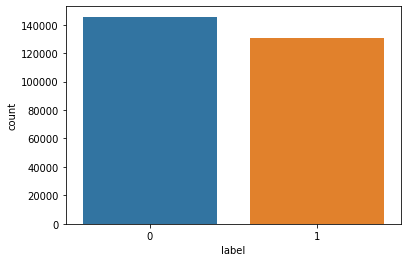

In [45]:
#checking distribution of target feature
sns.countplot(data=test_y, x='label')
plt.show()

### Loading Trained Model

In [46]:
# READ
s3_client = boto3.client('s3')

with tempfile.TemporaryFile() as fp:
    s3_client.download_fileobj(Fileobj=fp, Bucket=bucket, Key=model_path_with_fname)
    fp.seek(0)
    model = joblib.load(fp)

In [47]:
pred = model.predict(test_X)
print("XGBClassifier:\n", classification_report(test_y, pred))
print("ROC AUC score for data: ", roc_auc_score(test_y, model.predict_proba(test_X)[:,1], average='weighted'))

XGBClassifier:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72    145620
           1       0.68      0.70      0.69    130992

    accuracy                           0.71    276612
   macro avg       0.70      0.71      0.70    276612
weighted avg       0.71      0.71      0.71    276612

ROC AUC score for data:  0.7830798545103437


In [52]:
print("XGBClassifier:\n", classification_report(test_y, nn['prediction']))
print("ROC AUC score for data: ", roc_auc_score(test_y, model.predict_proba(test_X)[:,1], average='weighted'))

XGBClassifier:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72    145620
           1       0.68      0.70      0.69    130992

    accuracy                           0.71    276612
   macro avg       0.70      0.71      0.70    276612
weighted avg       0.71      0.71      0.71    276612

ROC AUC score for data:  0.7830798545103437


In [122]:
print('Metrics Score on best XGBoost model on Testing Set')
print('Recall:'.ljust(20, " "),recall_score(test_y, pred, average='weighted'))
print('Precision: '.ljust(20, " "),precision_score(test_y, pred, average='weighted'))
print('F1: '.ljust(20, " "),f1_score(test_y, pred, average='weighted'))
print('Simple Accuracy: '.ljust(20, " "),accuracy_score(test_y, pred))
print('ROC AUC: '.ljust(20, " "),roc_auc_score(test_y, model.predict_proba(test_X)[:,1], average='weighted'))
print('AUPRC: '.ljust(20, " "),average_precision_score(test_y, model.predict_proba(test_X)[:,1], average='weighted'))

Metrics Score on best XGBoost model on Testing Set
Recall:              0.7054285425071942
Precision:           0.7058667076756684
F1:                  0.7055636768829139
Simple Accuracy:     0.7054285425071942
ROC AUC:             0.7830798545103437
AUPRC:               0.7742254691987969


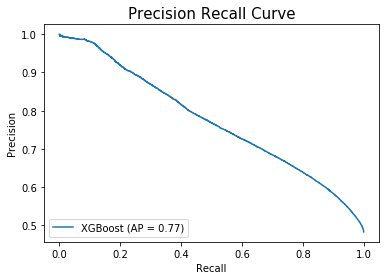

In [123]:
plot_precision_recall_curve(estimator=model, X=test_X, y=test_y, response_method='predict_proba', name='XGBoost')
plt.title('Precision Recall Curve', size=15)
plt.savefig('Precision Recall Curve - XGBoost.png')
plt.show()

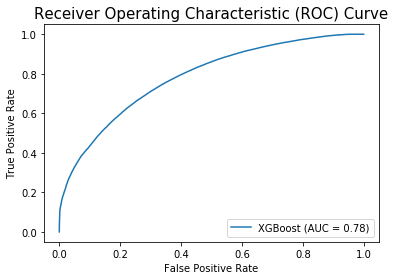

In [124]:
plot_roc_curve(estimator=model, X=test_X, y=test_y, response_method='predict_proba', name='XGBoost')
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
plt.savefig('Receiver Operating Characteristic (ROC) Curve.png')
plt.show()

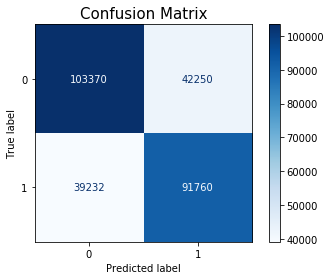

In [125]:
plot_confusion_matrix(estimator=model, X=test_X, y_true=test_y, cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix', size=15)
plt.savefig('Confusion Matrix.png')
plt.show()